# Deep Learning with KERAS

This interactive Python Notebook is based on https://github.com/fchollet/deep-learning-with-python-notebooks.
Before we start, we have to import KERAS in Python...

In [10]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import keras
keras.__version__

'2.2.4'

For those of you unfamiliar with Jupyter notebooks, this is a concise explanation.
Each "cell" of the notebook (a rectangular area) contains either explanatory text ("Markdown," like this cell) or Python/Keras commands ("Code"). By clicking on this cell, you select it (and the contours are highlighted). If you press "__Run__" in the menu, Jupyter processes the contents of this cell and moves on to the next. Scroll to the next cell, read the command and press __Run__ again. The result of the command (if any) will become visible. Just proceed through the notebook in this fashion, and return to previous cells, whenever necessary (either to re-read an explanation or command, or to change parameters). Please note that if you want to restart the entire notebook, you have to start at the top.

The notebook contains a number of questions that you have to answer, these questions are meant to help you to understand what is happening.

This notebook introduces the training of 10 perceptrons with KERAS, a publicly available deep-learning library. KERAS runs on top of Tensorflow and other deep-learning frameworks. Documentation on KERAS can be found at https://keras.io/.

Briefly explained, a perceptron is a simple neural network that has $I$ inputs. All $I$ inputs are connected to a single output. The $I$ connection weights, are trained to ensure that the output is activated whenever the inputs contain certain patterns. In our example, we train 10 perceptrons simultaneously on the same input to recognize handwritten digits '0' to '9'. Each perceptron takes care of detecting one of the digits; their output should become activated whenever one of the digits '0' to '9' appears in the input. The 10 outputs of the perceptrons are normalized to sum to one, so that their indivisual values can be interpreted as probabilities. The output with the largest probability given a certain input is the classification of the input. 

![](Perceptron.png)
>_Illustration of the 10 combined perceptrons._

The perceptrons are trained on the well-known MNIST dataset of handwritten digits. Each instance is a 28 x 28 pixel grayscale image and there are 10 targets (labels), i.e., '0', '1', .... '9'. The 28 x 28 pixel values are flattened to yield 784 inputs. Hence, in our combined perceptron, the number of inputs I is equal to 784.

The MNIST dataset consists of 60,000 training instances and 10,000 test 
instances. 

KERAS provides the MNIST dataset as a set of Numpy arrays: the training instances, the associated labels, the test instances and the associated labels.

In [11]:
from keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

The MLP is trained on the training instances by presenting them together with their labels to the network. Below, we examine the shape of the training instances.

In [12]:
train_images.shape

(60000, 28, 28)

The 6000 images are represented in a 3-dimensional array. Let's visualise the first 8 images.

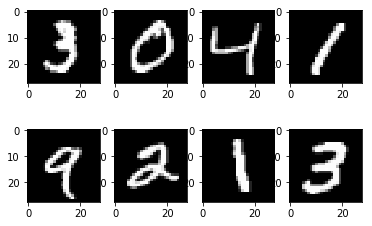

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.subplot(241)
plt.imshow(train_images[10].reshape(28,28), cmap=plt.get_cmap('gray'))
plt.subplot(242)
plt.imshow(train_images[1].reshape(28,28), cmap=plt.get_cmap('gray'))
plt.subplot(243)
plt.imshow(train_images[2].reshape(28,28), cmap=plt.get_cmap('gray'))
plt.subplot(244)
plt.imshow(train_images[3].reshape(28,28), cmap=plt.get_cmap('gray'))
plt.subplot(245)
plt.imshow(train_images[4].reshape(28,28), cmap=plt.get_cmap('gray'))
plt.subplot(246)
plt.imshow(train_images[5].reshape(28,28), cmap=plt.get_cmap('gray'))
plt.subplot(247)
plt.imshow(train_images[6].reshape(28,28), cmap=plt.get_cmap('gray'))
plt.subplot(248)
plt.imshow(train_images[7].reshape(28,28), cmap=plt.get_cmap('gray'))
# show the plot
plt.show()

We now turn to the training labels. Their number should equal the number of images (60000).

In [14]:
len(train_labels)

60000

What are the unique labels? (Should be '0' to '9')

In [15]:
import numpy as np
np.unique(train_labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

Are the labels (more-or-less) balanced? Are there about as many instances of each class?

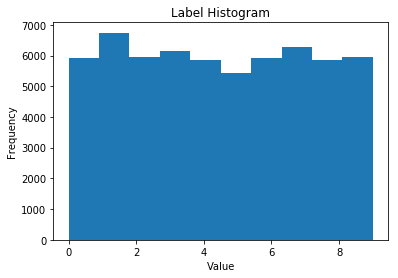

In [16]:
plt.hist(train_labels)

plt.title("Label Histogram")
plt.xlabel("Value")
plt.ylabel("Frequency")

fig = plt.gcf()

Let's have a look at the test data:

In [17]:
test_images.shape

(10000, 28, 28)

Our workflow will be as follows: first we will present our neural network with the training data, `train_images` and `train_labels`. The network will then learn to associate images and labels. Finally, we will ask the network to produce predictions for `test_images`, and we will verify if these predictions match the labels from `test_labels`.

Let's build our network. It consists of an input layer of $28 \times 28$ elements (each pixel value is an input, and the image matrix is represented in a vector of length $I = 28^2$). The output layer which has $10$ outputs, one for each class. 

In [18]:
from keras import models
from keras import layers

network = models.Sequential()
network.add(layers.Dense(10, use_bias='true', activation='softmax', input_shape=(28 * 28,)))

We randomly initialize the weights by drawing from a normal distribution with mean 0 and standard deviation 0.05. The random seed ensures that you get exactly the same sequence of random numbers when you repeat the experiment. 

__Q1. What is the effect of varying the random initialisation on your results?__

In [19]:
keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=156324)


The core building block of neural networks is the "layer", a data-processing module which you can conceive as a "filter" for data. Some 
data comes in, and comes out in a more useful form. Precisely, layers extract _representations_ out of the data fed into them -- hopefully 
representations that are more meaningful for the problem at hand. Most of deep learning really consists of chaining together simple layers 
which will implement a form of progressive "data distillation". A deep learning model is like a sieve for data processing, made of a 
succession of increasingly refined data filters -- the "layers".

Here our network consists of a single `Dense` layer,  also called a "fully-connected" neural layer. 
The output layer is a 10-way "softmax" layer, which means it will return an array of 10 probability scores (summing to 1). Each 
score will be the probability that the current digit image belongs to one of our 10 digit classes.

To make our network ready for training, we need to pick three more things, as part of "compilation" step:

* A loss function: the is how the network will be able to measure how good a job it is doing on its training data, and thus how it will be 
able to steer itself in the right direction.
* An optimizer: this is the mechanism through which the network will update itself based on the data it sees and its loss function.
* Metrics to monitor during training and testing. Here we will only care about accuracy (the fraction of the images that were correctly 
classified).

The exact purpose of the loss function and the optimizer will be made clear later during the course.

In [20]:
keras.optimizers.SGD(lr=0.01)

network.compile(optimizer='sgd',
                loss='categorical_crossentropy',
                metrics=['accuracy'])


Before training, we will preprocess our data by reshaping it into the shape that the network expects, and scaling it so that all values are in 
the `[0, 1]` interval. Previously, our training images for instance were stored in an array of shape `(60000, 28, 28)` of type `uint8` with 
values in the `[0, 255]` interval. We transform it into a `float32` array of shape `(60000, 28 * 28)` with values between 0 and 1.

In [21]:
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype('float32') / 255

We also need to categorically encode the labels, a step which we explain in chapter 3:

In [22]:
from keras.utils import to_categorical

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

We are now ready to train our network, which in Keras is done via a call to the `fit` method of the network: 
we "fit" the model to its training data. The number of epochs may be changed to study its effect on the final result (see Q4, below).
The "batch_size" specifies the number of input patterns (instances) per weight update. A smaller batch size is more precise, but takes longer. A larger batch size may not be very precise, but is much faster.

__Q2: Experiment with several batch sizes to determine how it affects the duration and accuracy of training. (If your computer is too slow, reduce the number of epochs for answering this question.)__

In [23]:
network.fit(train_images, train_labels, epochs=20, batch_size=20)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
60000/60000 [==============================] - 2s 35us/step - loss: 0.6633 - acc: 0.8395
Epoch 2/10
60000/60000 [==============================] - 2s 32us/step - loss: 0.4087 - acc: 0.8899
Epoch 3/10
60000/60000 [==============================] - 2s 32us/step - loss: 0.3684 - acc: 0.8984
Epoch 4/10
60000/60000 [==============================] - 2s 32us/step - loss: 0.3479 - acc: 0.9032
Epoch 5/10
60000/60000 [==============================] - 2s 32us/step - loss: 0.3348 - acc: 0.9066
Epoch 6/10
60000/60000 [==============================] - 2s 32us/step - loss: 0.3254 - acc: 0.9089
Epoch 7/10
60000/60000 [==============================] - 2s 32us/step - loss: 0.3181 - acc: 0.9110
Epoch 8/10
60000/60000 [==============================] - 2s 32us/step - loss: 0.3124 - acc: 0.9127
Epoch 9/10
60000/60000 [==============================] - 2s 32us/step - loss: 0.3077 - acc: 0.9141
Epoch 10/10
60000/60000 [===========================

Two quantities are being displayed during training: the "loss" of the network over the training data, and the accuracy of the network over 
the training data. The loss should be as small as possible (it is a measure of the error the network makes on classifying handwritten digits). The accuracy ("acc") is the percentage correctly classified digits for the __training__ data. Please note that this number should be sufficiently high, but does not reveal anything about prediction, but instead specifies the degree of replication. In order to know how well the trained perceptrons generalize, we have to determine their performance on the test set.

Typically, the performance (accuracy) on the test set tends to be lower than the performance on the training set.

In [24]:
test_loss, test_acc = network.evaluate(test_images, test_labels)

10000/10000 [==============================] - 0s 11us/step


In [25]:
print('test_acc:', test_acc)

test_acc: 0.9185


__Q3: Why is this the case?__

__Q4: How depends the difference in performance on train and test set on the number of epochs for training?__

An interesting feature of a perceptron (and of other neural networks) trained on images, is that we can visualise the weights after training. Each output has 26 x 26 weights forming a vector of 784 elements. Reshaping the vector in the matrix form that corresponds to that of the input image, allows us to visually interpret the weight patterns for each of the outputs.

In [26]:
W1 = network.layers[0].get_weights()[0]
WW = W1.reshape(28,28,10)
WW.shape

(28, 28, 10)

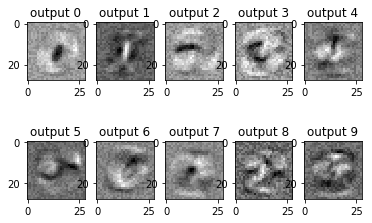

In [27]:
plt.subplot(2,5,1)
plt.imshow(WW[:,:,0], cmap=plt.get_cmap('gray'))
plt.title('output 0')
plt.subplot(2,5,2)
plt.imshow(WW[:,:,1], cmap=plt.get_cmap('gray'))
plt.title('output 1')
plt.subplot(2,5,3)
plt.imshow(WW[:,:,2], cmap=plt.get_cmap('gray'))
plt.title('output 2')
plt.subplot(2,5,4)
plt.imshow(WW[:,:,3], cmap=plt.get_cmap('gray'))
plt.title('output 3')
plt.subplot(2,5,5)
plt.imshow(WW[:,:,4], cmap=plt.get_cmap('gray'))
plt.title('output 4')
plt.subplot(2,5,6)
plt.imshow(WW[:,:,5], cmap=plt.get_cmap('gray'))
plt.title('output 5')
plt.subplot(2,5,7)
plt.imshow(WW[:,:,6], cmap=plt.get_cmap('gray'))
plt.title('output 6')
plt.subplot(2,5,8)
plt.imshow(WW[:,:,7], cmap=plt.get_cmap('gray'))
plt.title('output 7')
plt.subplot(2,5,9)
plt.imshow(WW[:,:,8], cmap=plt.get_cmap('gray'))
plt.title('output 8')
plt.subplot(2,5,10)
plt.imshow(WW[:,:,9], cmap=plt.get_cmap('gray'))
plt.title('output 9')

# show the plot
plt.show()

__Q5: What do you observe when inspecting the 10 weight matrices? Can you explain why the weights show these patterns?__

__Q6: How do the images depend on the number of epochs used for training?__